In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from utils import get_backend_properties_v1
from mlp import MLP1, MLP2, MLP3, encode_data

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise, RemoveReadoutErrors
from mlp import recursive_dict_loop, count_gates_by_rotation_angle
from mbd_utils import calc_imbalance
import torch
from torch import nn
from sklearn import datasets
import sklearn
from utils import circuit_to_graph_data_json
from utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
)
from qiskit.circuit.random import random_circuit
from sklearn.model_selection import train_test_split
import gate_dict

In [15]:
from typing import Optional, List, Dict, Union, Any

import numpy as np
import torch
from qiskit import QuantumCircuit
from qiskit.circuit import Qubit
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit import DAGOpNode, DAGInNode, DAGOutNode
from qiskit.opflow import PauliSumOp
from qiskit.primitives import BaseEstimator
from qiskit.providers import BackendV1
from qiskit.quantum_info import random_pauli_list, SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator as AerEstimator
from torch_geometric.data import Data

In [16]:
def circuit_to_graph_data_json(
    circuit: QuantumCircuit,
    properties: dict,
    use_gate_features: bool = False,
    use_qubit_features: bool = False,
):
    """Converts circuit to json (dict) for PyG data.

    Args:
        circuit: quantum circuit
        properties: call get_backend_properties_v1 for backend
        use_gate_features: use gate features in data graph
        use_qubit_features: use qubit features in data graph
    """

    # feature map for gate types
    additional_gate_types = [
        "barrier",
        "measure",
        # "delay"
    ]
    gate_type_feature_map = {
        g_name: index
        for index, g_name in enumerate(properties["gates_set"] + additional_gate_types)
    }

    # convert to dag
    dag_circuit = circuit_to_dag(circuit)

    nodes = list(dag_circuit.nodes())
    edges = list(dag_circuit.edges())

    # get node data
    nodes_dict: Dict[str, Dict[str, Any]] = {
        "DAGOpNode": {},
        "DAGInNode": {},
        "DAGOutNode": {},
    }

    circuit_n_qubits = circuit.num_qubits

    for node in nodes:
        if isinstance(node, DAGOpNode):

            # qubit features
            qubit_properties = {i: {} for i in range(3)}  # as 3 is max number of operable gate size
            if node.name != 'barrier' and len(node.qargs) > 3:
                raise Exception("Non barrier gate that has more than 3 qubits."
                                "Those tyoe of gates are not supported yet.")

            if node.name != 'barrier':  # barriers are more than 3 qubits
                for i, qubit in enumerate(node.qargs):
                    qubit_properties[i] = properties["qubits_props"][qubit.index]

            t1_vector = [v.get("t1", 0.0) for v in qubit_properties.values()]
            t2_vector = [v.get("t2", 0.0) for v in qubit_properties.values()]
            readout_error_vector = [
                v.get("readout_error", 0.0) for v in qubit_properties.values()
            ]

            qubit_feature_vector = t1_vector + t2_vector + readout_error_vector

            # gate features
            index = len(list(nodes_dict["DAGOpNode"].keys()))

            instruction_key = (
                f"{node.op.name}_"
                f"{'_'.join([str(args.index) for args in list(node.qargs)])}"
            )

            gate_props = properties["gate_props"].get(instruction_key, {})
            gate_props = {**{"gate_error": 0.0, "gate_length": 0.0}, **gate_props}
            if "index" in gate_props:
                del gate_props["index"]

            # one hot encoding of gate type
            gate_type_feature = [0.0 for _ in range(len(gate_type_feature_map))]
            gate_type_feature[gate_type_feature_map[node.op.name]] = 1.0

            # gate parameter values feature vector
            gate_params_feature_vector = [
                0.0,
                0.0,
                0.0,
            ]  # 3 is max number of parameter in any instruction
            for idx, p in enumerate(node.op.params):
                if isinstance(p, (float, int)):
                    gate_params_feature_vector[idx] = float(p)
                elif p.is_real():
                    gate_params_feature_vector[idx] = float(p._symbol_expr)

            # gate properties
            gate_props_feature_vector = [
                gate_props["gate_error"],
                gate_props["gate_length"],
            ]

            feature_vector = gate_params_feature_vector + gate_type_feature
            if use_qubit_features:
                feature_vector += qubit_feature_vector
            if use_gate_features:
                feature_vector += gate_props_feature_vector

            nodes_dict["DAGOpNode"][node] = {
                "index": index,
                "type": "DAGOpNode",
                "name": node.op.name,
                "num_qubits": node.op.num_qubits,
                "num_clbits": node.op.num_clbits,
                "params": [],
                "feature_vector": feature_vector,
                **gate_props,
            }

        elif isinstance(node, (DAGInNode, DAGOutNode)):
            node_type_key = str(type(node)).split("'")[1].split(".")[-1]
            index = len(list(nodes_dict[node_type_key].keys()))
            nodes_dict[node_type_key][node] = {
                "index": index,
                "type": node_type_key,
                "register": node.wire.register.name,
                "bit": node.wire.index,
                "feature_vector": [0, 0],
            }

    # get edge data
    edge_dict = {}

    for edge in edges:
        source, dest, wire = edge
        source_type = str(type(source)).split("'")[1].split(".")[-1]
        dest_type = str(type(dest)).split("'")[1].split(".")[-1]

        source = nodes_dict[source_type][source]
        dest = nodes_dict[dest_type][dest]

        if isinstance(wire, Qubit):
            edge_attrs = properties["qubits_props"][wire.index]
            key = (source_type, "wire", dest_type)

            if key not in edge_dict:
                edge_dict[key] = {
                    "edge_index": [[source["index"], dest["index"]]],
                    "edge_attr": [
                        [
                            edge_attrs["t1"],
                            edge_attrs["t2"],
                            edge_attrs["readout_error"],
                        ]
                    ],
                }
            else:
                edge_dict[key]["edge_index"].append([source["index"], dest["index"]])
                edge_dict[key]["edge_attr"].append(
                    [edge_attrs["t1"], edge_attrs["t2"], edge_attrs["readout_error"]]
                )

    data: Dict[str, Dict[str, Any]] = {"nodes": {}, "edges": {}}

    for key, d in edge_dict.items():
        edge_index = np.array(d["edge_index"]).T.tolist()
        edge_attr = d["edge_attr"]

        data["edges"]["_".join(list(key))] = {
            "edge_index": edge_index,
            "edge_attr": edge_attr,
        }

    return data

In [17]:
backend = FakeLima()

In [18]:
def create_train_and_test_data(n_qubits: int, 
                               circuit_depth: int, 
                               pauli_terms: int, 
                               pauli_coeff: float = 1.0, 
                               max_entries: int = 10, 
                               properties = get_backend_properties_v1(backend)):
    
    circuits_list = []
    ideal_exp_vals_list = []
    noisy_exp_vals_list = []

    for _ in range(max_entries):
        qc = random_circuit(n_qubits, random.randint(1, circuit_depth))

        observable = generate_random_pauli_sum_op(n_qubits, pauli_terms, pauli_coeff)

        ideal_exp_val, noisy_exp_val = create_estimator_meas_data(
            backend=backend, circuit=qc, observable=observable
        )

        circuits_list.append(qc)
        ideal_exp_vals_list.append(ideal_exp_val)
        noisy_exp_vals_list.append(noisy_exp_val)

    return circuits_list, ideal_exp_vals_list, noisy_exp_vals_list

In [26]:
# circ specified 
n_qubits = 2
circ_depth = 2
pauli_terms = 1

In [27]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals = create_train_and_test_data(n_qubits=n_qubits,
                                                                                        circuit_depth=circ_depth,
                                                                                        pauli_terms=pauli_terms,
                                                                                        max_entries=5)

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = create_train_and_test_data(n_qubits=n_qubits,
                                                                                    circuit_depth=circ_depth,
                                                                                    pauli_terms=pauli_terms,
                                                                                    max_entries=1)

In [28]:
circ = train_circuits[0]

In [29]:
transpiled_circ = transpile(circ, backend, optimization_level=0)

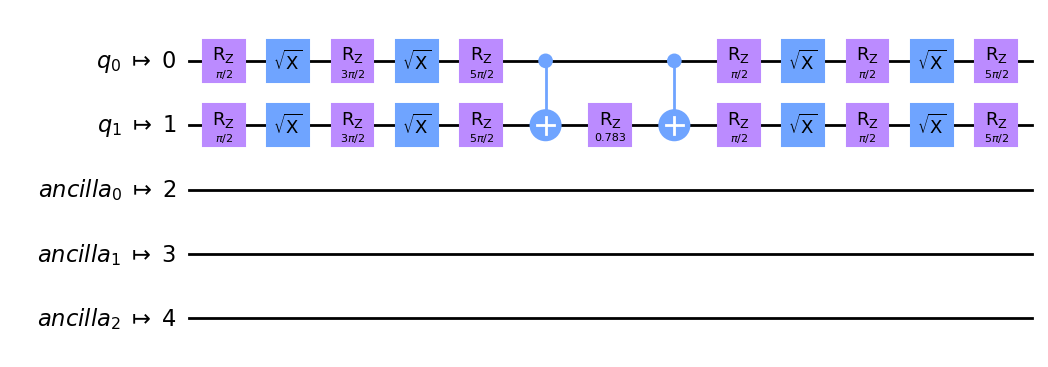

In [30]:
transpiled_circ.draw('mpl')

In [31]:
qc_data = circuit_to_graph_data_json(transpiled_circ, get_backend_properties_v1(backend), True, True)

In [32]:
qc_data

{'nodes': {},
 'edges': {'DAGInNode_wire_DAGOpNode': {'edge_index': [[0, 1], [0, 5]],
   'edge_attr': [[5.9698643286635694e-05,
     9.355584184359312e-05,
     0.026100000000000012],
    [8.305997230317399e-05, 0.00011553074510239035, 0.020000000000000018]]},
  'DAGInNode_wire_DAGOutNode': {'edge_index': [[2, 3, 4], [2, 3, 4]],
   'edge_attr': [[0.00010377694598809795,
     9.477169960638749e-05,
     0.016599999999999948],
    [4.358447375590962e-05, 4.645933441447346e-05, 0.0515000000000001],
    [1.7543975812787366e-05, 1.6441110002077736e-05, 0.057499999999999996]]},
  'DAGOpNode_wire_DAGOpNode': {'edge_index': [[0,
     1,
     2,
     3,
     4,
     5,
     6,
     7,
     8,
     9,
     10,
     10,
     11,
     12,
     12,
     13,
     14,
     15,
     16,
     18,
     19,
     20,
     21],
    [1,
     2,
     3,
     4,
     10,
     6,
     7,
     8,
     9,
     10,
     12,
     11,
     12,
     18,
     13,
     14,
     15,
     16,
     17,
     19,
     20,
